In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import umap
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm


In [ ]:

BASE_DIR = Path("./result_data")
EMB_DIR = BASE_DIR / "embeddings"
EMB_AUG_DIR = BASE_DIR / "embeddings_aug"

def load_embeddings_with_aug(emb_dir, emb_aug_dir):
    X, y, y_type = [], [], []
    for file in tqdm(list(emb_dir.glob("*.npy")), desc="Загрузка эмбеддингов"):
        name = file.stem
        embs = np.load(file)
        X.append(embs)
        y.extend([name] * len(embs))
        y_type.extend(["orig"] * len(embs))

        # --- пробуем найти аугментированные ---
        aug_file = emb_aug_dir / file.name
        if aug_file.exists():
            embs_aug = np.load(aug_file)
            X.append(embs_aug)
            y.extend([name] * len(embs_aug))
            y_type.extend(["aug"] * len(embs_aug))

    X = np.vstack(X)
    y = np.array(y)
    y_type = np.array(y_type)
    return X, y, y_type

X, y, y_type = load_embeddings_with_aug(EMB_DIR, EMB_AUG_DIR)
print(f"Загружено {len(X)} эмбеддингов для {len(np.unique(y))} актёров")


Загрузка эмбеддингов:   0%|          | 0/528 [00:00<?, ?it/s]

Загружено 18120 эмбеддингов для 528 актёров


In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    verbose=True
)
X_umap = reducer.fit_transform(X)



/home/davidik67/miniconda3/envs/facenet-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sun Oct 19 15:58:18 2025 Construct fuzzy simplicial set
Sun Oct 19 15:58:18 2025 Finding Nearest Neighbors
Sun Oct 19 15:58:18 2025 Building RP forest with 12 trees
Sun Oct 19 15:58:23 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Oct 19 15:58:36 2025 Finished Nearest Neighbor Search
Sun Oct 19 15:58:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Oct 19 15:59:47 2025 Finished embedding


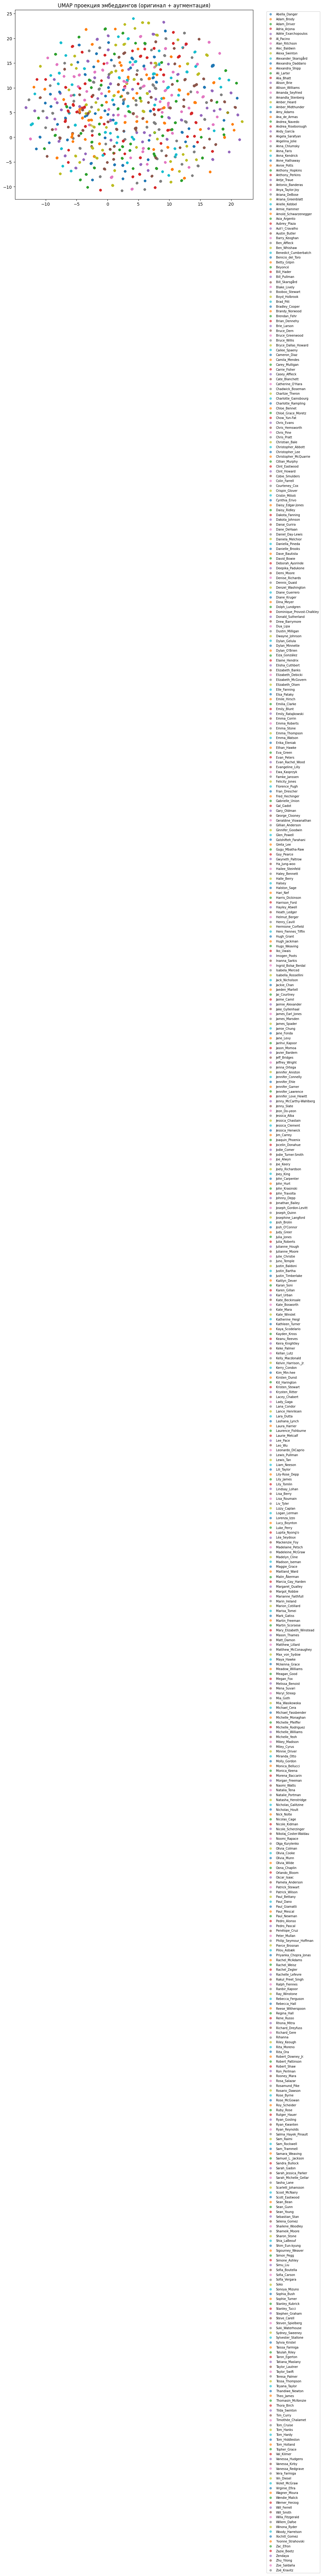

In [4]:
plt.figure(figsize=(10, 8))
for name in np.unique(y):
    idx = y == name
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=20,
        alpha=0.6,
        label=name
    )
plt.legend(fontsize=7, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("UMAP проекция эмбеддингов (оригинал + аугментация)")
plt.show()

In [6]:
import plotly.express as px
import pandas as pd

# Делаем DataFrame для удобства
df = pd.DataFrame({
    "x": X_umap[:, 0],
    "y": X_umap[:, 1],
    "actor": y,
    "type": y_type  # orig / aug
})

In [ ]:
fig = px.scatter(
    df,
    x="x", y="y",
    color="actor",
    symbol="type",  # разные маркеры для оригинала и аугментации
    title="UMAP проекция эмбеддингов (оригинал + аугментация)",
    hover_data=["actor", "type"],
    opacity=0.7,SЫ
    width=900, height=700
)

fig.update_layout(showlegend=False)

fig.show()


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

X_tsne = TSNE(
    n_components=2,
    metric="cosine",
    perplexity=30,
    learning_rate="auto",
    random_state=42
).fit_transform(X)

df_tsne = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "actor": y,
    "type": y_type if 'y_type' in locals() else ["orig"] * len(y)
})

fig = px.scatter(
    df_tsne,
    x="x", y="y",
    color="actor",
    symbol="type",  # orig / aug
    hover_data=["actor", "type"],
    title="t-SNE проекция эмбеддингов (оригинал + аугментация)",
    opacity=0.7,
    width=900, height=700
)

fig.update_layout(showlegend=False)

fig.show()


# Оценка качества кластеризации

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


def neighbor_purity(X, y, k=5):
    """
    Возвращает среднюю долю "правильных соседей" — эмбеддингов той же личности.
    """
    nn = NearestNeighbors(n_neighbors=k+1, metric="cosine", n_jobs=-1).fit(X)
    _, idxs = nn.kneighbors(X)
    correct = 0
    for i in range(len(X)):
        neighbors = y[idxs[i][1:]]
        correct += np.sum(neighbors == y[i]) / k
    return correct / len(X)

purity_orig = neighbor_purity(X[y_type == "orig"], y[y_type == "orig"])
purity_aug  = neighbor_purity(X[y_type == "aug"],  y[y_type == "aug"])

print(f"Оригинальные эмбеддинги: {purity_orig:.3f}")
print(f" Аугментированные эмбеддинги: {purity_aug:.3f}")
purity_local = neighbor_purity(X, y, k=5)
purity_mean = purity_local.mean()
print(f"редняя доля правильных соседей (вкл. аугм.): {purity_mean:.3f}")

Оригинальные эмбеддинги: 0.989
 Аугментированные эмбеддинги: 0.989
редняя доля правильных соседей (вкл. аугм.): 0.996
